In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from casadi import *
%matplotlib notebook

## Simulation

(100, 4)


<IPython.core.display.Javascript object>


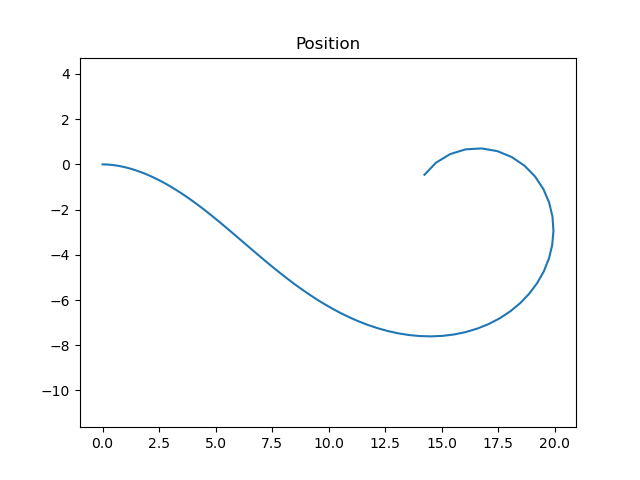

<IPython.core.display.Javascript object>


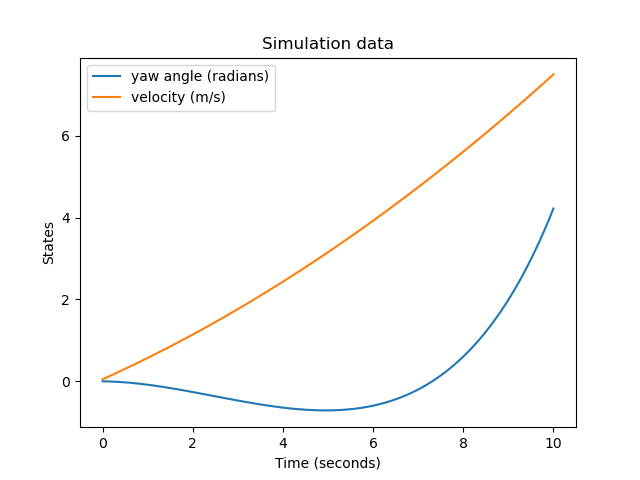

In [2]:
# Total simulation time (seconds)
T = 10

# delta-time (Resolution)
dt = 0.1  # 0.1 seconds

# Number of simulation time-steps
steps = int(T/dt)

# Ground truth states
X_gt = []

# Simulation Time
t = np.linspace(0, T, steps)

# Generating sine-wave acceleration commands
U = np.array([
    np.linspace(0.5, 1, steps), # acceration input
    np.linspace(-np.pi/4, np.pi/4, steps)  # steering input
]).T

# wheel base length
l = 2.7  # meters

def motion_model(X, U, dt):
    new_X = copy.deepcopy(X)
    new_X[0] = X[0] + X[3] * cos(X[2]) * dt
    new_X[1] = X[1] + X[3] * sin(X[2]) * dt
    new_X[2] = X[2] + X[3] * tan(U[1])/l * dt
    new_X[3] = X[3] + U[0] * dt
    
    return new_X

# Specifying initial state
X = np.array([
    [0.0],
    [0.0],
    [0.0],
    [0.0]
])

# Simulation loop
for i in range(U.shape[0]):
    X = motion_model(X, U[i, :], dt)
    X_gt.append(np.array(X))
    
# Converting into numpy array
X_gt = np.squeeze(np.array(X_gt))

print(X_gt.shape)


# Plotting the simulation data
plt.figure()
plt.plot(X_gt[:, 0], X_gt[:,1])
plt.axis("equal")
plt.title("Position")

plt.figure()
plt.plot(t, X_gt[:, 2], label='yaw angle (radians)')
plt.plot(t, X_gt[:, 3], label='velocity (m/s)')
plt.title('Simulation data')
plt.xlabel('Time (seconds)')
plt.ylabel('States')
plt.legend(loc='best')
plt.show()

## Generating noisy data

<IPython.core.display.Javascript object>


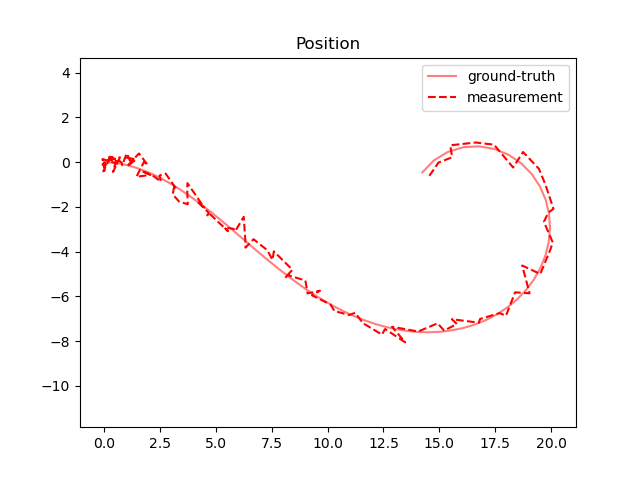

<IPython.core.display.Javascript object>


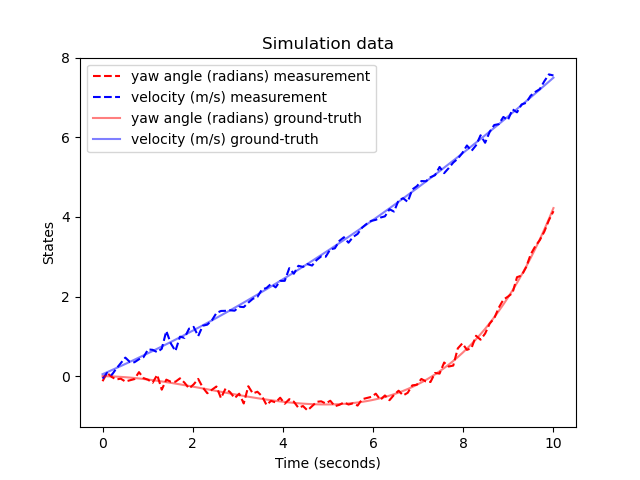

In [3]:
# Converting into numpy array
X_noisy = copy.deepcopy(X_gt)

# Adding gaussian noise
X_noisy[:,0] += np.random.normal(loc=0, scale=0.25, size=X_noisy.shape[0]).T
X_noisy[:,1] += np.random.normal(loc=0, scale=0.25, size=X_noisy.shape[0]).T
X_noisy[:,2] += np.random.normal(loc=0, scale=0.1, size=X_noisy.shape[0]).T
X_noisy[:,3] += np.random.normal(loc=0, scale=0.1, size=X_noisy.shape[0]).T

# Plotting the simulation data
plt.figure()
plt.plot(X_gt[:, 0], X_gt[:,1], 'r', label='ground-truth', alpha=0.5)
plt.plot(X_noisy[:, 0], X_noisy[:,1], 'r--', label='measurement')
plt.axis("equal")
plt.title("Position")
plt.legend(loc='best')

plt.figure()
plt.plot(t, X_noisy[:, 2], 'r--', label='yaw angle (radians) measurement')
plt.plot(t, X_noisy[:, 3], 'b--', label='velocity (m/s) measurement')
plt.plot(t, X_gt[:, 2], 'r', label='yaw angle (radians) ground-truth', alpha=0.5)
plt.plot(t, X_gt[:, 3], 'b', label='velocity (m/s) ground-truth', alpha=0.5)
plt.title('Simulation data')
plt.xlabel('Time (seconds)')
plt.ylabel('States')
plt.legend(loc='best')
plt.show()

## Extended Kalman Filter

<IPython.core.display.Javascript object>


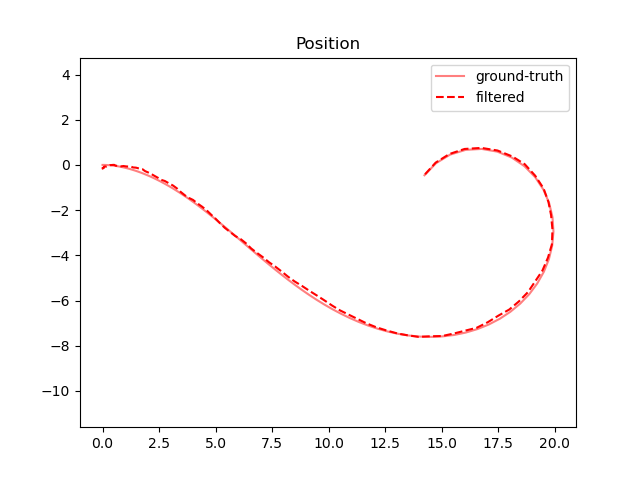

<IPython.core.display.Javascript object>


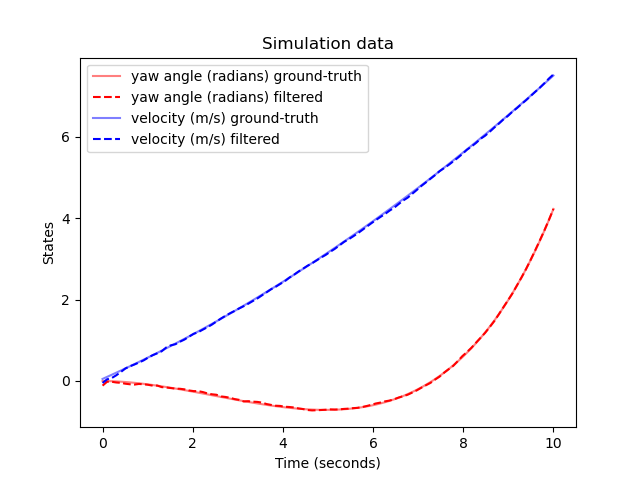

In [6]:
X_filtered = []

# Using the same controls generated in the simulation
# Using the same wheel base as simulation

# Measurement model
def measurement_model(X):
    """
    This function takes Xi, Ui and dt as input and returns the next state Xi+1
    """
    
    new_X = copy.deepcopy(X)
    
    return new_X

# Process covariance (In our case it should be zero, because our control applied during
# simuation had no noisy actuation, but still we will consider some level of process noise
# just for the sake of this implementation)
Q = np.eye(4)           # 3x3 process noise matrix
Q[0, 0] = 0.025 **2     # x variance
Q[1, 1] = 0.025 **2    # y variance
Q[2, 2] = 0.01 **2      # theta variance
Q[3, 3] = 0.01 **2      # v variance

# Measurement covariance (amount of noise in measured quantities)
R = np.eye(4)       # 3x3 measurement noise matrix
R[0, 0] = 0.5 **2     # x measurement variance
R[1, 1] = 0.5 **2   # y measurement variance
R[2, 2] = 0.1 **2  # theta measurement variance
R[3, 3] = 0.1 **2  # v measurement variance

# Specifying initial state
X = np.array([
    [0.0],
    [0.0],
    [0.0],
    [0.0]
])

# Initial process covariance (confidence in intial state specified)
P = np.eye(len(X)) * 0.1

# Simulating
for i in range(U.shape[0]):
    
    # ==== PREDICTION STEP ====
    # 1. Finding the A matrix by linearizing around the best estimate
    V = MX.sym('V', 4)  # State vector representation

    # Defining motion function
    f = vertcat(V[0] + V[3] * np.cos(V[2]) * dt, 
                V[1] + V[3] * np.sin(V[2]) * dt, 
                V[2], 
                V[3])
    
    # Calculating jacobian
    J = Function('A', [V], [jacobian(f, V)])
    
    # Applying control
    f += vertcat(0, 
                0, 
                (V[3] * np.tan(U[i, 1])/l) * dt, 
                U[i, 0] * dt)

    # Evaluating jacobian at X
    A = np.array(J(X))
    
    # 2. Extrapolating the state
    F = Function('F', [V], [f])
    X = F(X)
    
    # 3. Extrapolating the process covariance matrix
    P = A@P@A.T + Q
    
    
    # Getting the noisy measurements from the sensor
    measurement = X_noisy[i, :]
    
    h = vertcat(V[0],
                V[1],
                V[2], 
                V[3])
    G = Function('G', [V], [jacobian(h, V)])
    H = np.array(G(X))
    
    
    # ==== CORRECTION STEP ====
    # 1. Kalman Gain
    K = P@H.T @ np.linalg.inv(H@P@H.T + R)
    
    # 2. Update State Estimate
    X = X + K @ (measurement - H@X)
    
    # 3. Update Estimate Uncertainity
    P = (np.eye(4) - K@H) @ P @ (np.eye(4) - K@H).T + K@R@K.T
    
    # Appending the filtered position to list
    X_filtered.append(np.array(X))

X_filtered = np.array(X_filtered)
    
# Plotting the simulation data
plt.figure()
plt.plot(X_gt[:, 0], X_gt[:,1], 'r', label='ground-truth', alpha=0.5)
plt.plot(X_filtered[:, 0], X_filtered[:,1], 'r--', label='filtered')
plt.axis("equal")
plt.title("Position")
plt.legend(loc='best')

plt.figure()
plt.plot(t, X_gt[:, 2], 'r', label='yaw angle (radians) ground-truth', alpha=0.5)
plt.plot(t, X_filtered[:, 2], 'r--', label='yaw angle (radians) filtered')
plt.plot(t, X_gt[:, 3], 'b', label='velocity (m/s) ground-truth', alpha=0.5)
plt.plot(t, X_filtered[:, 3], 'b--', label='velocity (m/s) filtered')
plt.title('Simulation data')
plt.xlabel('Time (seconds)')
plt.ylabel('States')
plt.legend(loc='best')
plt.show()